In [30]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [31]:
import numpy as np
import pandas as pd

In [32]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [33]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc

In [34]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [35]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [36]:
# We can view all of the classes that automap found
Base.classes.keys()

inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [37]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [38]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Climate Analysis













In [39]:
 #Design a query to retrieve the last 12 months of precipitation data and plot the results
    
meas_columns = inspector.get_columns('measurement')
for column in meas_columns:
    print(column["name"], column["type"])


id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [40]:
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date = str(most_recent_date)[2:-3]
print(most_recent_date)

2017-08-23


In [41]:
 #Calculate the date 1 year ago from the last data point in the database
year_from_now = dt.date(2017,8,23)-dt.timedelta(days=365)
print(year_from_now)

2016-08-23


In [42]:
 #Perform a query to retrieve the data and precipitation scores
 #Save the query results as a Pandas DataFrame and set the index to the date column
measure_query = session.query(Measurement.date,Measurement.prcp).filter(Measurement.date>=year_from_now).all()
measurement_df_1year = pd.DataFrame(measure_query)
measurement_df_1year.head()
    


,date,prcp
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00


In [43]:
# Use Pandas to calcualte the summary statistics for the precipitation data

In [44]:
# Sort the dataframe by date
measurement_df_1year.sort_index()
measurement_df_1year.head()

,date,prcp
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00


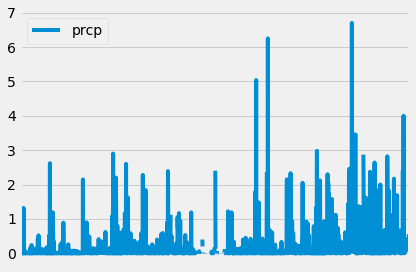

In [45]:
# Use Pandas Plotting with Matplotlib to plot the da
measurement_df_1year.plot()
plt.xticks([])
plt.tight_layout()
plt.show()

![describe](Images/describe.png)

In [46]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(func.count(Station.station))
station_count = stations[0]
station_count


(9)

In [47]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
observations = session.query(Measurement.station, func.count(Measurement.tobs))\
             .group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc())

for station in observations:
    print(station)


('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [48]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
top_station = observations[0][0]

stats = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).filter(Measurement.station == top_station)
                      
stats_list=list(stats)
print(stats_list)


[(54.0, 85.0, 71.66378066378067)]


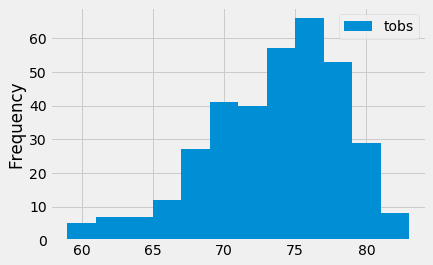

In [49]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs = session.query(Measurement.tobs)\
.filter(Measurement.date >= year_from_now)\
.filter(Measurement.date <= most_recent_date)\
.filter(Measurement.station == top_station)\

tobs_list = []
for tob in tobs:
    tobs_list.append(tob[0])
    
fig = plt.figure()
plt.hist(tobs_list, bins=12 , label='tobs')
plt.ylabel("Frequency")
plt.legend(loc=1)
plt.savefig("station_observation_analysis.png")
plt.show()


In [50]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2016-01-01', '2016-01-08'))

[(62.0, 69.91666666666667, 76.0)]


In [51]:

# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates

# Define start and end date
start_date = '2016-01-01'
end_date = '2016-01-08'

def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """

    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps(start_date, end_date))


[(62.0, 69.91666666666667, 76.0)]


In [52]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

prev_year_start = str(eval(start_date[0:4])-1) + start_date[4:]
prev_year_end = str(eval(end_date[0:4])-1) + end_date[4:]

last_year_temp_analysis = calc_temps(prev_year_start, prev_year_end)

tmin = last_year_temp_analysis[0][0]
tmax = last_year_temp_analysis[0][1]
tavg = last_year_temp_analysis[0][2]

print(last_year_temp_analysis)

[(56.0, 64.9672131147541, 74.0)]


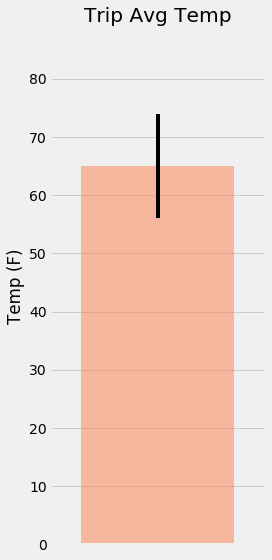

In [53]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

fig, ax = plt.subplots(figsize=plt.figaspect(2.))

bar= ax.bar(1, tmax, yerr=(tmax-tmin),alpha=0.5, color="coral")
ax.set(xticks=range(1), xticklabels="a", title="Trip Avg Temp", ylabel = "Temp (F)")
ax.margins(.2,.2)
fig.tight_layout()

plt.savefig("temperature_analysis.png")
plt.show()

In [54]:

# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

prcptrip_query = engine.execute('SELECT measurement.station, name, latitude, longitude, elevation, AVG(prcp) FROM measurement \
LEFT JOIN station ON measurement.station = station.station \
WHERE date BETWEEN "2016-01-01" AND "2016-01-08" GROUP BY measurement.station ORDER BY AVG(prcp) DESC').fetchall()
prcptrip_query


[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.36750000000000005),
 ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.11875),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.07),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.027500000000000004),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.02375),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.021666666666666667),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]

## Optional Challenge Assignment

In [55]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [56]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [57]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [58]:
# Plot the daily normals as an area plot with `stacked=False`